<a href="https://colab.research.google.com/github/aimlrl/Object-Detection-through-Tensorflow-2-Object-Detection-API/blob/master/Completely_Commented_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# First we will create the required directories 

In [2]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
! mkdir Pose_Estimation

mkdir: cannot create directory ‘Pose_Estimation’: File exists


In [4]:
cd /content/drive/MyDrive/Pose_Estimation

/content/drive/MyDrive/Pose_Estimation


In [5]:
! mkdir Dataset

In [6]:
cd /content/drive/MyDrive/Pose_Estimation/Dataset

/content/drive/MyDrive/Pose_Estimation/Dataset


# Downloading the annotations data

In [7]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2022-06-28 17:53:35--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.96.172
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.96.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  50.2MB/s    in 4.8s    

2022-06-28 17:53:40 (50.0 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [8]:
!unzip /content/drive/MyDrive/Pose_Estimation/Dataset/annotations_trainval2017.zip

Archive:  /content/drive/MyDrive/Pose_Estimation/Dataset/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


# Importing the dependancies

In [3]:
import os
import pandas as pd
import tensorflow.compat.v1 as tf
from PIL import Image
from collections import namedtuple
import glob
import io
import numpy as np
import json

In [10]:
root_dir = "/content/drive/MyDrive/Pose_Estimation"

In [11]:
def compile_examples(json_annotations):

  file_handle = open(json_annotations)
  annotations = json.load(file_handle)

  image_urls = list()

  for image_detail in annotations["images"]:
    image_urls.append(image_detail["coco_url"])

  image_ids = list()

  for single_annotation in annotations["annotations"]:
    image_ids.append(single_annotation["image_id"])

  urls_dict = dict()

  for img_url in image_urls:
    urls_dict[img_url.split("/")[-1]] = img_url

  image_details = dict()
  images_added = list()

  for single_annotation in annotations["annotations"]:

    img_filename = "000000"+str(single_annotation["image_id"])+".jpg"

    keypoints = np.array(single_annotation["keypoints"]).reshape(17,3)
    gt_validity = keypoints[:,2] > 0

    if img_filename in list(urls_dict.keys()) and sum(gt_validity) > 0 \
    and single_annotation["iscrowd"] == 0 and single_annotation["bbox"][2] > 48 and single_annotation["bbox"][3] > 64:

      images_added.append(img_filename)
      image_details[img_filename] = dict()
      image_details[img_filename]["url"] = urls_dict[img_filename]
      image_details[img_filename]["num_keypoints"] = single_annotation["num_keypoints"]
      image_details[img_filename]["bbox"] = single_annotation["bbox"]
      image_details[img_filename]["keypoints"] = single_annotation["keypoints"]

  return image_details

In [12]:
training_annotations = compile_examples("/content/drive/MyDrive/Pose_Estimation/Dataset/annotations/person_keypoints_train2017.json")

json_string = json.dumps(training_annotations)
json_file_handle = open("training_annotations.json","w")
json_file_handle.write(json_string)
json_file_handle.close()

In [13]:
cv_annotations = compile_examples("/content/drive/MyDrive/Pose_Estimation/Dataset/annotations/person_keypoints_val2017.json")

json_string = json.dumps(cv_annotations)
json_file_handle = open("cv_annotations.json","w")
json_file_handle.write(json_string)
json_file_handle.close()

In [14]:
training_file_handle = open("/content/drive/MyDrive/Pose_Estimation/Dataset/training_annotations.json")
training_annotations = json.load(training_file_handle)

In [15]:
cv_file_handle = open("/content/drive/MyDrive/Pose_Estimation/Dataset/cv_annotations.json")
cv_annotations = json.load(cv_file_handle)

In [16]:
cd /content/drive/MyDrive/Pose_Estimation

/content/drive/MyDrive/Pose_Estimation


In [17]:
! mkdir person_train_images
! mkdir person_cv_train_images

In [4]:
import requests
import time
from requests.exceptions import ConnectionError

In [19]:
! sudo python3 -m pip install "requests[security]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 4.0 MB 60.5 MB/s 


In [20]:
! pip install pyopenssl ndg-httpsclient pyasn1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
def download_image(image_filename):

  tries = 0
  while True:
    tries = tries + 1
    try:
      r = requests.get(training_annotations[image_filename]["url"])
      file_handle = open(os.path.join("/content/drive/MyDrive/Pose_Estimation/person_train_images",image_filename),"wb")
      file_handle.write(r.content)
      file_handle.close()
      print("Written {}".format(image_filename))
      break
    except ConnectionError as err:
      if tries == 11:
        raise err
      else:
        time.sleep(1)

In [22]:
def download_cv_image(image_filename):

  tries = 0
  while True:
    tries = tries + 1
    try:
      r = requests.get(cv_annotations[image_filename]["url"])
      file_handle = open(os.path.join("/content/drive/MyDrive/Pose_Estimation/person_cv_train_images",image_filename),"wb")
      file_handle.write(r.content)
      file_handle.close()
      print("Written {}".format(image_filename))
      break
    except ConnectionError as err:
      if tries == 11:
        raise err
      else:
        time.sleep(1)

In [23]:
from concurrent.futures import ThreadPoolExecutor

In [24]:
with ThreadPoolExecutor() as executor:
  executor.map(download_image,training_annotations.keys())

Streaming output truncated to the last 5000 lines.
Written 000000285041.jpg
Written 000000333152.jpg
Written 000000560576.jpg
Written 000000364090.jpg
Written 000000453424.jpg
Written 000000538270.jpg
Written 000000487870.jpg
Written 000000322297.jpg
Written 000000141678.jpg
Written 000000358242.jpg
Written 000000108238.jpg
Written 000000320892.jpg
Written 000000361659.jpg
Written 000000429158.jpg
Written 000000135576.jpg
Written 000000358646.jpg
Written 000000497567.jpg
Written 000000313118.jpg
Written 000000334645.jpg
Written 000000461484.jpg
Written 000000150769.jpg
Written 000000109076.jpg
Written 000000327573.jpg
Written 000000540814.jpg
Written 000000261633.jpg
Written 000000469779.jpg
Written 000000262145.jpg
Written 000000528345.jpg
Written 000000416258.jpg
Written 000000560513.jpg
Written 000000365265.jpg
Written 000000464812.jpg
Written 000000541208.jpg
Written 000000493468.jpg
Written 000000284667.jpg
Written 000000272412.jpg
Written 000000256105.jpg
Written 000000365996.jpg

In [27]:
with ThreadPoolExecutor(max_workers=4) as executor:
  executor.map(download_cv_image,cv_annotations.keys())

Written 000000433915.jpg
Written 000000292456.jpg
Written 000000139099.jpg
Written 000000425226.jpg
Written 000000251140.jpg
Written 000000481567.jpg
Written 000000458992.jpg
Written 000000102331.jpg
Written 000000165681.jpg
Written 000000579902.jpg
Written 000000395180.jpg
Written 000000182611.jpg
Written 000000357737.jpg
Written 000000279278.jpg
Written 000000494869.jpg
Written 000000329219.jpg
Written 000000122166.jpg
Written 000000546976.jpg
Written 000000380706.jpg
Written 000000394199.jpg
Written 000000464476.jpg
Written 000000424162.jpg
Written 000000492937.jpg
Written 000000169996.jpg
Written 000000397133.jpg
Written 000000146667.jpg
Written 000000289343.jpg
Written 000000579321.jpg
Written 000000422706.jpg
Written 000000261888.jpg
Written 000000445834.jpg
Written 000000507975.jpg
Written 000000246963.jpg
Written 000000577932.jpg
Written 000000338304.jpg
Written 000000176857.jpg
Written 000000534605.jpg
Written 000000226408.jpg
Written 000000356387.jpg
Written 000000210299.jpg


In [5]:
import matplotlib.pyplot as plt
import cv2
from PIL import UnidentifiedImageError
from scipy.ndimage import gaussian_filter

Try to complete the code below. Let's give you a hint, we are actually trying to generate the ground truth labels (keypoints) but not in the form of a matrix of shape (17,3) but in 3D matrix of shape:

$(\frac{1}{4}*$Width of the warped cropped person image, $\frac{1}{4}*$Height of the warped cropped person image, 17$)$

Therefore, it can be said that the ground truth matrix of (17,3) is actually been converted into an image whose dimensions will be equal to the dimensions of the input warped image with 17 channels, called ground truth heatmap. Each channel of the ground truth heatmap will ba having all the pixels with zero pixel intensity except at the location of one of a ground truth keypoint location. Furthermore, to add little bit noise to the pixel intensity at the location of one of the keypoints at it's respective channel of the heatmap, all the channels are convolved with gaussian filter.

Now, why the ground truth label is called heatmap. It is called heatmap because there are 17 channels of the ground truth heatmap with each channel corresponding to one of the ground truth keypoints and the region in that specific channel of a ground truth keypoint is brighten at the location of that specific keypoint in the image. 

To know more about gaussian filter, you can navigate to this link: 
https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html

So, the size of the input warped image will be (256,192,3). This size has been actually taken from the following research paper: 
https://arxiv.org/abs/1804.06208

Therefore, the gound truth label matrix of keypoints of shape (17,3) will be converted into ground truth heatmap of shape ($\frac{1}{4}*$256, $\frac{1}{4}*$192, 17) = (64,48,17). We are converting the output into a smaller but not the same size as input warped image size becauase we don't want to increase the computational complexity of the training and loss function computation and it is also recommended in the above paper. 

In [6]:
def create_gt_heatmap_labels(img,annotations,resize_shape=(64,48)):

  gt_heatmap = np.zeros(shape=(17,resize_shape[0],resize_shape[1]))
  keypoints = np.array(annotations[img]["keypoints"]).reshape(17,3)
  xmin,ymin,w,h = annotations[img]["bbox"]
  bbox_offset = np.array([xmin,ymin,0])
  bbox_dims = np.array([w,h,1])
  gt_heatmap_dims = np.array([resize_shape[1],resize_shape[0],1])
  keypoints = np.round((keypoints - bbox_offset)*gt_heatmap_dims/bbox_dims).astype(int)

  for i in range(17):

    if keypoints[i,2] > 0:
      y = keypoints[i,0]
      x = keypoints[i,1]

      if x < 0 or y < 0 or x >= resize_shape[0] or y >= resize_shape[1]:
        keypoints[i,2] = 0.0
        continue

      gt_heatmap[i,x,y] = 1.0
      gt_heatmap[i,:,:] = gaussian_filter(input=gt_heatmap[i,:,:],sigma=2,mode="constant",cval=0.0)
      gt_heatmap[i,:,:] = gt_heatmap[i,:,:]/np.max(gt_heatmap[i,:,:]) #Doubt in this

  gt_validity = keypoints[:,2] > 0
  gt_validity = gt_validity.reshape(gt_validity.shape[0],1,1)

  return gt_heatmap.astype(float), gt_validity.astype(float)

The below function is the custom data generator for generating the batches of training examples. Every single batch will be having 32 warped cropped images of persons that is the size of each batch of input images will be (32,256,192,3) and also the respective heatmaps of each of the warped cropped images in the batch, that is (32,64,48,17). This custom data generator is going to get the ground truth heatmaps from the function above by calling it. 

In [7]:
def train_generator(train_images,annotations,batch_size=32,resize_shape=(256,192)):

  num_train_images = len(train_images)
  train_images = np.array(train_images)
  img_norm_mean = np.array([0.485,0.456,0.456])
  img_norm_std = np.array([0.229,0.224,0.225])

  while True:

    for offset in range(0,num_train_images,batch_size):
      
      batch_images = list(np.random.choice(train_images,size=batch_size,replace=False))
      images_batch = []
      gt_heatmaps_batch = []
      gt_validities_batch = []

      for img in batch_images:

        try:
          image = Image.open(os.path.join("/content/drive/MyDrive/Pose_Estimation/person_train_images",img))
          xmin,ymin,w,h = annotations[img]["bbox"]
          cropped_image = image.resize(size=(resize_shape[1],resize_shape[0]),box=(xmin,ymin,xmin+w,ymin+h))
          cropped_image = np.array(cropped_image)

          if len(cropped_image.shape) != 3:
            cropped_image = np.stack((cropped_image,)*3,axis=-1)

          cropped_image = cropped_image.astype(float)/255.0
          cropped_image = (cropped_image - img_norm_mean)/img_norm_std

          cropped_image = cropped_image.reshape(resize_shape[0],resize_shape[1],3)
          images_batch.append(cropped_image)

          gt_heatmap,gt_validity = create_gt_heatmap_labels(img,annotations)
          gt_heatmaps_batch.append(gt_heatmap)
          gt_validities_batch.append(gt_validity)

        except UnidentifiedImageError as err:
          continue

      images_batch = np.array(images_batch)
      gt_heatmaps_batch = np.array(gt_heatmaps_batch)
      gt_validities_batch = np.array(gt_validities_batch)

      yield images_batch,gt_heatmaps_batch,gt_validities_batch

In [8]:
def cv_generator(cv_images,annotations,batch_size=32,resize_shape=(256,192)):

  num_cv_train_images = len(cv_images)
  img_norm_mean = np.array([0.485,0.456,0.456])
  img_norm_std = np.array([0.229,0.224,0.225])

  while True:

    for offset in range(0,num_cv_train_images,batch_size):
      
      batch_images = cv_images[offset:offset+batch_size]
      images_batch = []
      gt_heatmaps_batch = []
      gt_validities_batch = []

      for img in batch_images:

        try:
          image = Image.open(os.path.join("/content/drive/MyDrive/Pose_Estimation/person_cv_train_images",img))
          xmin,ymin,w,h = annotations[img]["bbox"]
          cropped_image = image.resize(size=(resize_shape[1],resize_shape[0]),box=(xmin,ymin,xmin+w,ymin+h))
          cropped_image = np.array(cropped_image)

          if len(cropped_image.shape) != 3:
            cropped_image = np.stack((cropped_image,)*3,axis=-1)

          cropped_image = cropped_image.astype(float)/255.0
          cropped_image = (cropped_image - img_norm_mean)/img_norm_std

          cropped_image = cropped_image.reshape(resize_shape[0],resize_shape[1],3)
          images_batch.append(cropped_image)

          gt_heatmap,gt_validity = create_gt_heatmap_labels(img,annotations)
          gt_heatmaps_batch.append(gt_heatmap)
          gt_validities_batch.append(gt_validity)

        except UnidentifiedImageError as err:
          continue

      images_batch = np.array(images_batch)
      gt_heatmaps_batch = np.array(gt_heatmaps_batch)
      gt_validities_batch = np.array(gt_validities_batch)

      yield images_batch,gt_heatmaps_batch,gt_validities_batch

# Build the Neural Network

In [9]:
from keras.layers import Conv2D,Conv2DTranspose,BatchNormalization
from keras.applications import resnet_v2
from keras.models import Model
from keras.layers import Input
from keras.layers import ReLU
from keras.layers import Reshape
from keras.initializers import random_normal
import tensorflow as tf
import keras

Read the above research paper and implement the Human Pose Estimation Neural Network using Keras:
https://arxiv.org/abs/1804.06208

and fill up the following function. 

In [10]:
def create_pretrained_pose_resnet(resize_shape=(64,48)):

  images_batch = Input(shape=(256,192,3))
  pretrained_resnet = resnet_v2.ResNet50V2(include_top=False,input_shape=(256,192,3))

  pretrained_resnet.trainable = False

  pretrained_resnet_output = pretrained_resnet(images_batch,training=False)

  pretrained_resnet_out = Conv2DTranspose(filters=256,kernel_size=4,strides=2,padding="same",
                                          kernel_initializer=random_normal(stddev=0.001))(pretrained_resnet_output)
  pretrained_resnet_out = BatchNormalization()(pretrained_resnet_out)
  pretrained_resnet_out = ReLU()(pretrained_resnet_out)

  pretrained_resnet_out = Conv2DTranspose(filters=256,kernel_size=4,strides=2,padding="same",
                                          kernel_initializer=random_normal(stddev=0.001))(pretrained_resnet_out)
  pretrained_resnet_out = BatchNormalization()(pretrained_resnet_out)
  pretrained_resnet_out = ReLU()(pretrained_resnet_out)

  pretrained_resnet_out = Conv2DTranspose(filters=256,kernel_size=4,strides=2,padding="same",
                                          kernel_initializer=random_normal(stddev=0.001))(pretrained_resnet_out)
  pretrained_resnet_out = BatchNormalization()(pretrained_resnet_out)
  pretrained_resnet_out = ReLU()(pretrained_resnet_out)

  pretrained_resnet_out = Conv2D(filters=17,kernel_size=1,kernel_initializer=random_normal(stddev=0.001))(pretrained_resnet_out)

  pretrained_resnet_out = Reshape((17,resize_shape[0],resize_shape[1]))(pretrained_resnet_out)

  pretrained_pose_resnet = Model(images_batch,pretrained_resnet_out)

  return pretrained_pose_resnet

In [11]:
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [12]:
#Doubt 
def mse_loss(heatmap_pred,heatmap_train,heatmap_val_train):

  heatmap_pred = heatmap_val_train * tf.cast(heatmap_pred,tf.float64)
  heatmap_train = heatmap_val_train * heatmap_train
  mse = mse_loss_fn(y_true=heatmap_train,y_pred=tf.cast(heatmap_pred,tf.float64))
  return mse

In [13]:
pose_estimate_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.00001)

In [14]:
pose_estimate_finetune_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0000001)

In [15]:
pretrained_pose_resnet = create_pretrained_pose_resnet()

94683136/94668760 [==============================] - 1s 0us/step


In [16]:
pretrained_pose_resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 6, 2048)        23564800  
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 12, 256)      8388864   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 12, 256)      1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16, 12, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 24, 256)      104883

In [39]:
cd /content/drive/MyDrive/Pose_Estimation

/content/drive/MyDrive/Pose_Estimation


In [40]:
! mkdir Finetune_checkpoints
! mkdir Checkpoints

In [17]:
pose_estimate_checkpoint_dir = ("/content/drive/MyDrive/Pose_Estimation/Checkpoints")
checkpoint_prefix = os.path.join(pose_estimate_checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(optimizer=pose_estimate_optimizer,model=pretrained_pose_resnet)

In [18]:
pose_estimate_finetune_checkpoint_dir = "/content/drive/MyDrive/Pose_Estimation/Finetune_checkpoints"
finetune_checkpoint_prefix = os.path.join(pose_estimate_finetune_checkpoint_dir,"ckpt")
finetune_checkpoint = tf.train.Checkpoint(optimizer = pose_estimate_finetune_optimizer,model = pretrained_pose_resnet)

In [19]:
@tf.function
def train_step(images_batch ,heatmap_train_batch ,heatmap_val_batch):
    
    with tf.GradientTape() as pose_estimate_tape:
        pretrained_pose_resnet.layers[1].trainable = False
        
        heatmap_pred_batch = pretrained_pose_resnet(images_batch,training = True)
        pose_estimate_loss = mse_loss(heatmap_pred=heatmap_pred_batch,heatmap_train=heatmap_train_batch,heatmap_val_train=heatmap_val_batch)
        
        pose_estimate_gradient = pose_estimate_tape.gradient(pose_estimate_loss,pretrained_pose_resnet.trainable_variables)
        pose_estimate_optimizer.apply_gradients(zip(pose_estimate_gradient ,pretrained_pose_resnet.trainable_variables))
        
    return heatmap_pred_batch , pose_estimate_loss        

In [20]:
@tf.function
def finetune_train_step(images_batch ,heatmap_train_batch ,heatmap_val_batch):
    
    pretrained_pose_resnet.trainable = True
    
    for layer in pretrained_pose_resnet.layers[1].layers[:-13]:
        layer.trainable = False
    
    with tf.GradientTape() as pose_estimate_tape:
        heatmap_pred_batch = pretrained_pose_resnet(images_batch,training = True)
        pose_estimate_loss = mse_loss(heatmap_pred=heatmap_pred_batch,heatmap_train=heatmap_train_batch,heatmap_val_train=heatmap_val_batch)
        pose_estimate_gradient = pose_estimate_tape.gradient(pose_estimate_loss ,pretrained_pose_resnet.trainable_variables)
        pose_estimate_finetune_optimizer.apply_gradients(zip(pose_estimate_gradient,pretrained_pose_resnet.trainable_variables))
    
    return heatmap_pred_batch ,pose_estimate_loss

In [21]:
@tf.function
def cv_step(cv_images_batch ,cv_heatmap_train_batch,cv_heatmap_val_batch):
    
    pretrained_pose_resnet.trainable =False
    cv_heatmap_pred_batch = pretrained_pose_resnet(cv_images_batch,training = False)
    pose_estimate_loss = mse_loss(heatmap_pred=cv_heatmap_pred_batch,heatmap_train=cv_heatmap_train_batch,
                                  heatmap_val_train=cv_heatmap_val_batch)
    
    return cv_heatmap_pred_batch,pose_estimate_loss

In [22]:
# ORIGINAL FROM HERE:
# https://github.com/microsoft/human-pose-estimation.pytorch/blob/715d29e55f59ae555116542e85ed7175d57120e6/lib/core/evaluate.py
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft
# Licensed under the MIT License.
# Written by Bin Xiao (Bin.Xiao@microsoft.com)
# ------------------------------------------------------------------------------
# Calculates Percentage of Correct Key-points (PCK) accuracy
# A detected joint is considered correct if the distance between the predicted 
# and the true joint is within a certain threshold. 


def get_max_preds(batch_heatmaps):
    '''
    get predictions from score maps
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    '''

    assert isinstance(batch_heatmaps, np.ndarray), 'batch_heatmaps should be numpy.ndarray'
    assert batch_heatmaps.ndim == 4, 'batch_images should be 4-ndim'

    batch_size = batch_heatmaps.shape[0]
    num_joints = batch_heatmaps.shape[1]
    width = batch_heatmaps.shape[3]
    heatmaps_reshaped = batch_heatmaps.reshape((batch_size, num_joints, -1))
    idx = np.argmax(heatmaps_reshaped, 2)
    maxvals = np.amax(heatmaps_reshaped, 2)

    maxvals = maxvals.reshape((batch_size, num_joints, 1))
    idx = idx.reshape((batch_size, num_joints, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)

    preds[:, :, 0] = (preds[:, :, 0]) % width
    preds[:, :, 1] = np.floor((preds[:, :, 1]) / width)

    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 1, 2))
    pred_mask = pred_mask.astype(np.float32)

    preds *= pred_mask
    return preds, maxvals

In [23]:

def calc_dists(preds, target, normalize):
    preds = preds.astype(np.float32)
    target = target.astype(np.float32)
    dists = np.zeros((preds.shape[1], preds.shape[0]))
    for n in range(preds.shape[0]):
        for c in range(preds.shape[1]):
            if target[n, c, 0] > 1 and target[n, c, 1] > 1:
                normed_preds = preds[n, c, :] / normalize[n]
                normed_targets = target[n, c, :] / normalize[n]
                dists[c, n] = np.linalg.norm(normed_preds - normed_targets)
            else:
                dists[c, n] = -1
    return dists

In [24]:
def dist_acc(dists, thr=0.5):
    ''' Return percentage below threshold while ignoring values with a -1 '''
    dist_cal = np.not_equal(dists, -1)
    num_dist_cal = dist_cal.sum()
    if num_dist_cal > 0:
        return np.less(dists[dist_cal], thr).sum() * 1.0 / num_dist_cal
    else:
        return -1

In [25]:
#PCK accurarcy stands for Percentage of Correct Keypoints Accurarcy
def accuracy(output, target, hm_type='gaussian', thr=0.5):
    '''
    Calculate accuracy according to PCK,
    but uses ground truth heatmap rather than x,y locations
    First value to be returned is average accuracy across 'idxs',
    followed by individual accuracies
    '''
    idx = list(range(output.shape[1]))
    norm = 1.0
    if hm_type == 'gaussian':
        pred, _ = get_max_preds(output.numpy())
        target, _ = get_max_preds(target)
        h = output.shape[2]
        w = output.shape[3]
        norm = np.ones((pred.shape[0], 2)) * np.array([h, w]) / 10
    dists = calc_dists(pred, target, norm)

    acc = np.zeros((len(idx) + 1))
    avg_acc = 0
    cnt = 0

    for i in range(len(idx)):
        acc[i + 1] = dist_acc(dists[idx[i]],thr=thr)
        if acc[i + 1] >= 0:
            avg_acc = avg_acc + acc[i + 1]
            cnt += 1

    avg_acc = avg_acc / cnt if cnt != 0 else 0
    if cnt != 0:
        acc[0] = avg_acc
    return avg_acc

The above four functions which you can see are taken from a github repository to implement the calculation of special kind of accuracy metric used for Human Pose Estimation Neural Network. This special kind of accuracy metric is called PCK Accuracy (Percentage of Correct Keypoints Accuracy). So, how it is evaluated ? Well, in short what we do is that for every prediction of the network of shape (64,48,17), we compute the difference between the location of predicted keypoints and location of ground truth keypoints for the 17 heatmaps and if the difference between the locations is less than 0.5 then we consider the predicted keypoint to be detected correctly and count it as correct keypoint detection and similarly we do it for all the other remaining 16 keypoints and then compute the fraction of correctly predicted keypoints out of 17 keypoints. 

Similarly, we do it for all the images in a batch of 32 images and take the average of the fraction of correct keypoints over all the batch of images. And that is what has been done in the above four functions. 

In [26]:
class pck_accuracy_metric(keras.metrics.Metric):

  def __init__(self,name="pck_accuracy",**kwargs):
    super().__init__(name=name,**kwargs)
    self.pck_avg_accuracy_sum = self.add_weight(name="pck_avg_accuracy_sum",initializer="zeros",dtype="float32")
    self.total_batches = self.add_weight(name="total_batches",initializer="zeros",dtype="int32")

  def update_state(self,y_true,y_pred,sample_weight=None):
    pck_avg_accuracy = accuracy(output=y_pred,target=y_true,thr=0.7)
    self.pck_avg_accuracy_sum.assign_add(pck_avg_accuracy)
    self.total_batches.assign_add(1)

  def result(self):
    return self.pck_avg_accuracy_sum/tf.cast(self.total_batches,tf.float32)

  def reset_state(self):
    self.pck_avg_accuracy_sum.assign(0.0)
    self.total_batches.assign(0)

In [27]:
def lr_scheduler(epoch,lr):
    
    lr = 1e-3

    if epoch > 120:
        lr *= 1e-2
    elif epoch > 90:
        lr *= 1e-1

    return lr

In [28]:
pose_train_acc_metric = pck_accuracy_metric()
pose_val_acc_metric = pck_accuracy_metric()

In [29]:
json_file_handle = open("/content/drive/MyDrive/Pose_Estimation/Dataset/training_annotations.json")
json_string = json_file_handle.read()
training_annotations = json.loads(json_string)

In [30]:
json_file_handle = open("/content/drive/MyDrive/Pose_Estimation/Dataset/cv_annotations.json")
json_string = json_file_handle.read()
cv_annotations = json.loads(json_string)

# Please also write the training loop to train the network below. 

In [31]:
epochs = 50
batch_size = 116
cv_batch_size = 149
finetune_epoch = 20

In [32]:
def train(epochs):
    train_images = os.listdir("/content/drive/MyDrive/Pose_Estimation/person_train_images")
    cv_images = os.listdir("/content/drive/MyDrive/Pose_Estimation/person_cv_train_images")
    
    cv_datagen = cv_generator(cv_images=cv_images,annotations=cv_annotations,
                             batch_size=cv_batch_size)
    
    #callback.on_train_begin()
    for epoch in range(epochs):
        time_step =1

        #callback.on_epoch_begin(epoch=epoch)
        for images_batch,gt_heatmaps_batch,gt_validities_batch in train_generator(train_images,training_annotations,
                                                                                 batch_size):
            heatmaps_pred_batch ,pose_estimate_loss = train_step(images_batch,gt_heatmaps_batch,gt_validities_batch)
            if time_step > len(os.listdir("/content/drive/MyDrive/Pose_Estimation/person_train_images"))//batch_size:
                break
            if time_step % 100==0:
                pose_train_acc_metric.update_state(gt_heatmaps_batch,heatmaps_pred_batch)
                training_acc_batch = pose_train_acc_metric.result()
                
                cv_time_step = 1
                avg_cv_loss = 0
                
                for cv_image_batch ,gt_cv_heatmap_batch ,gt_cv_validities_batch in cv_generator(cv_images,cv_annotations,
                                                                                                batch_size=cv_batch_size ):
                    cv_heatmap_pred_batch ,cv_pose_estimate_loss = cv_step(cv_image_batch,gt_cv_heatmap_batch,gt_cv_validities_batch)
                    
                    if cv_time_step > len(os.listdir("/content/drive/MyDrive/Pose_Estimation/person_cv_train_images"))//cv_batch_size:
                        break
                    
                    pose_val_acc_metric.update_state(gt_cv_heatmap_batch,cv_heatmap_pred_batch)
                    avg_cv_loss += float(cv_pose_estimate_loss)
                    cv_time_step += 1
                    
                avg_cv_loss = avg_cv_loss /float(cv_time_step)
                cv_pck_accuracy = pose_val_acc_metric.result()
                
#                 cv_images_batch,cv_gt_heatmaps_batch,cv_gt_validities_batch = next(cv_datagen)
#                 cv_heatmaps_pred_batch,pose_estimate_cv_loss = cv_step(cv_images_batch,cv_gt_heatmaps_batch,cv_gt_validities_batch)
#                 pose_val_acc_metric.update_state(cv_gt_heatmaps_batch,cv_heatmaps_pred_batch)
#                 cv_pck_accuracy = pose_val_acc_metric.result()
                
                print("Epoch: {} Time Step: {} \nTraining Loss: {} Training Accuracy: \n{} Val Loss: {} Val Accuracy: {}".format(epoch,time_step,float(pose_estimate_loss),
                                                                                                                     float(training_acc_batch),
                                                                                                                     float(cv_pose_estimate_loss),
                                                                                                                     float(cv_pck_accuracy)))
                pose_train_acc_metric.reset_state()
                pose_val_acc_metric.reset_state()
                
            print("Epoch: {},Time Step: {}".format(epoch + 1,time_step))
            
            time_step += 1
        checkpoint.save(file_prefix=checkpoint_prefix)

In [33]:
def finetune_train(epochs):
    train_images = os.listdir("/content/drive/MyDrive/Pose_Estimation/person_train_images")
    cv_images = os.listdir("/content/drive/MyDrive/Pose_Estimation/person_cv_train_images")
    
    cv_datagen = cv_generator(cv_images=cv_images,annotations=cv_annotations,
                             batch_size=cv_batch_size)
    for epoch in range(epochs):
        time_step =1
        for images_batch,gt_heatmaps_batch,gt_validities_batch in train_generator(train_images,training_annotations,
                                                                                 batch_size):
            heatmaps_pred_batch ,pose_estimate_loss = finetune_train_step(images_batch,gt_heatmaps_batch,gt_validities_batch)
            if time_step > len(os.listdir("/content/drive/MyDrive/Pose_Estimation/person_train_images"))//batch_size:
                break
            
            if time_step %100==0:
                pose_train_acc_metric.update_state(gt_heatmaps_batch,heatmaps_pred_batch)
                training_acc_batch = pose_train_acc_metric.result()
                
                cv_time_step = 1
                avg_cv_loss = 0
                
                for cv_image_batch ,gt_cv_heatmap_batch ,gt_cv_validities_batch in cv_generator(cv_images,cv_annotations,
                                                                                                batch_size=cv_batch_size ):
                    cv_heatmap_pred_batch ,cv_pose_estimate_loss = cv_step(cv_image_batch,gt_cv_heatmap_batch,gt_cv_validities_batch)
                    
                    if cv_time_step > len(os.listdir("/content/drive/MyDrive/Pose_Estimation/person_cv_train_images"))//cv_batch_size:
                        break
                    
                    pose_val_acc_metric.update_state(gt_cv_heatmap_batch,cv_heatmap_pred_batch)
                    avg_cv_loss += float(cv_pose_estimate_loss)
                    cv_time_step += 1
                    
                avg_cv_loss = avg_cv_loss /float(cv_time_step)
                cv_pck_accuracy = pose_val_acc_metric.result()
                
                print("Epoch: {} Time Step: {} Training Loss: {} \nTraining Accuracy: {} \nVal Loss: {} Val Accuracy: {}".format(epoch,time_step,float(pose_estimate_loss),
                                                                                                                     float(training_acc_batch),
                                                                                                                     float(cv_pose_estimate_loss),
                                                                                                                     float(cv_pck_accuracy)))
                pose_train_acc_metric.reset_state()
                pose_val_acc_metric.reset_state()
                
            print("Epoch: {},Time Step: {}".format(epoch + 1,time_step))
            
            time_step += 1
        finetune_checkpoint.save(file_prefix=finetune_checkpoint_prefix)
    

In [ ]:
train(epochs)

Epoch: 1,Time Step: 1
Epoch: 1,Time Step: 2
Epoch: 1,Time Step: 3
Epoch: 1,Time Step: 4
Epoch: 1,Time Step: 5
Epoch: 1,Time Step: 6
Epoch: 1,Time Step: 7
Epoch: 1,Time Step: 8
Epoch: 1,Time Step: 9
Epoch: 1,Time Step: 10
Epoch: 1,Time Step: 11
Epoch: 1,Time Step: 12
Epoch: 1,Time Step: 13
Epoch: 1,Time Step: 14
Epoch: 1,Time Step: 15
Epoch: 1,Time Step: 16
Epoch: 1,Time Step: 17
Epoch: 1,Time Step: 18
Epoch: 1,Time Step: 19
Epoch: 1,Time Step: 20
Epoch: 1,Time Step: 21
Epoch: 1,Time Step: 22
Epoch: 1,Time Step: 23
Epoch: 1,Time Step: 24
Epoch: 1,Time Step: 25
Epoch: 1,Time Step: 26
Epoch: 1,Time Step: 27
Epoch: 1,Time Step: 28
Epoch: 1,Time Step: 29
Epoch: 1,Time Step: 30
Epoch: 1,Time Step: 31
Epoch: 1,Time Step: 32
Epoch: 1,Time Step: 33
Epoch: 1,Time Step: 34
Epoch: 1,Time Step: 35
Epoch: 1,Time Step: 36
Epoch: 1,Time Step: 37
Epoch: 1,Time Step: 38
Epoch: 1,Time Step: 39
Epoch: 1,Time Step: 40
Epoch: 1,Time Step: 41
Epoch: 1,Time Step: 42
Epoch: 1,Time Step: 43
Epoch: 1,Time Step: 

In [ ]:
# tf.train.get_checkpoint_state(checkpoint_dir="C:/Users/Mask/Desktop/AIML Projects/Human Pose Detection/Checkpoints",
#                          latest_filename="ckpt-12" )

In [34]:
latest_checkpoint = tf.train.latest_checkpoint("/content/drive/MyDrive/Pose_Estimation/Checkpoints" )                                               
latest_checkpoint

'/content/drive/MyDrive/Pose_Estimation/Checkpoints/ckpt-3'

In [35]:
checkpoint.restore(latest_checkpoint)

In [37]:
finetune_train(10)

OSError: ignored

In [38]:
latest_finetune_ckpt = tf.train.latest_checkpoint("/content/drive/MyDrive/Pose_Estimation/Finetune_checkpoints")
latest_finetune_ckpt

In [39]:
finetune_checkpoint.restore(latest_finetune_ckpt)

In [40]:
cv_images = os.listdir("/content/drive/MyDrive/Pose_Estimation/person_cv_train_images")
cv_datagen = cv_generator(cv_images,cv_annotations,batch_size=cv_batch_size)

In [41]:
def plotting_data(test_img,heatmap,test_validity):

  test_img = test_img[0]

  mean=np.array([0.485, 0.456, 0.406])
  std=np.array([0.229, 0.224, 0.225])

  test_img = test_img*std + mean
  heatmap = np.sum(heatmap[0],axis=0)

  fig = plt.figure(2,figsize=(20,20))
  plt.gray()

  ax1 = fig.add_subplot(121)
  ax1.imshow(test_img)

  ax2 = fig.add_subplot(122)
  ax2.imshow(heatmap)
  
  plt.show()

In [42]:
cv_imgs_batch,cv_gt_heatmaps_batch,cv_gt_validities_batch = next(cv_datagen)
single_cv_img = cv_imgs_batch[0,:,:,:]
single_cv_img = single_cv_img.reshape(1,single_cv_img.shape[0],single_cv_img.shape[1],single_cv_img.shape[2])
single_cv_gt_heatmap = cv_gt_heatmaps_batch[0,:,:,:]
single_cv_gt_heatmap = single_cv_gt_heatmap.reshape(1,single_cv_gt_heatmap.shape[0],single_cv_gt_heatmap.shape[1],single_cv_gt_heatmap.shape[2])
single_cv_gt_validity = cv_gt_validities_batch[0,:,:,:]
single_cv_gt_validity = single_cv_gt_validity.reshape(1,single_cv_gt_validity.shape[0],single_cv_gt_validity.shape[1],single_cv_gt_validity.shape[2])

In [43]:
single_cv_img.shape

(1, 256, 192, 3)

In [44]:
single_cv_gt_heatmap.shape

(1, 17, 64, 48)

In [45]:
single_cv_gt_validity.shape

(1, 17, 1, 1)

In [46]:
pretrained_pose_resnet.trainable = False
cv_img_heatmap_pred = pretrained_pose_resnet(single_cv_img,training=False)

In [47]:
cv_img_heatmap_pred

<tf.Tensor: shape=(1, 17, 64, 48), dtype=float32, numpy=
array([[[[-7.07715866e-04,  5.55421168e-04,  8.60905566e-04, ...,
           5.19754179e-03,  4.86560306e-03,  4.62786062e-03],
         [ 4.12014546e-03,  5.58341108e-03,  6.45106472e-03, ...,
           6.44003134e-03,  8.34613387e-03,  8.36039241e-03],
         [ 8.30338430e-03,  9.03478358e-03,  9.02517140e-03, ...,
           2.38041505e-02,  2.39593722e-02,  2.45161578e-02],
         ...,
         [ 2.03418476e-03,  2.71010818e-03,  1.51995663e-03, ...,
           3.27460526e-04, -1.37121335e-03, -1.33878749e-03],
         [ 2.69142620e-05,  2.25146743e-03,  2.52891844e-03, ...,
           7.78348825e-04,  2.81267241e-03,  2.33734073e-03],
         [ 3.04924557e-03,  3.77013464e-03,  1.83478196e-03, ...,
           3.98236141e-03,  1.41122506e-03,  1.94701343e-03]],

        [[ 1.86743413e-03,  7.73587730e-04, -1.21996462e-04, ...,
          -3.39039892e-04, -9.18435457e-04, -2.43755116e-04],
         [-3.07841023e-04, -2.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GROUNDTRUTH HEATMAP


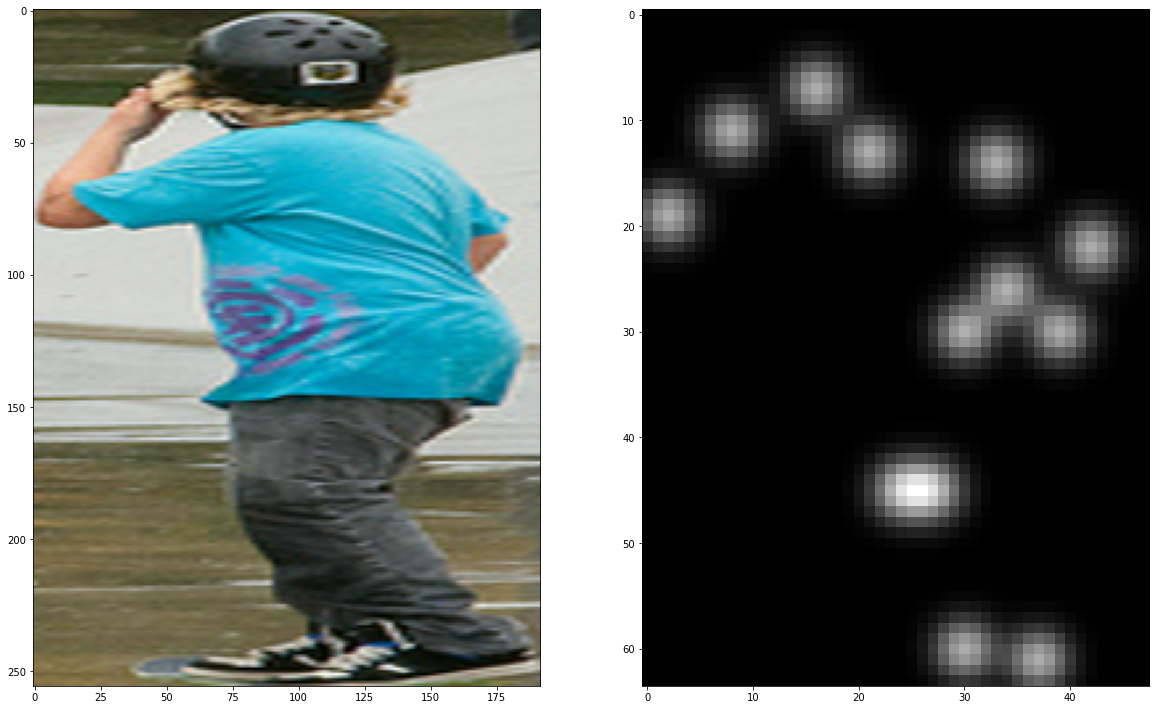

In [48]:
print("GROUNDTRUTH HEATMAP")
plotting_data(single_cv_img,single_cv_gt_heatmap,single_cv_gt_validity)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTED HEATMAP


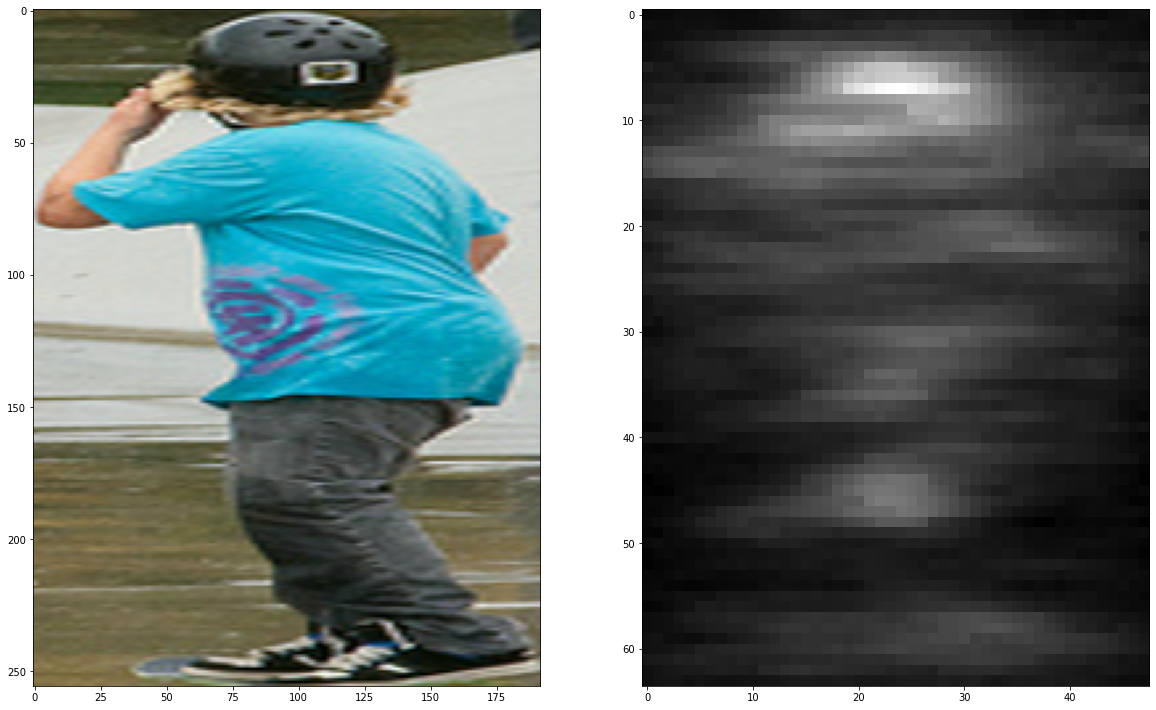

In [49]:
print("PREDICTED HEATMAP")
plotting_data(single_cv_img,cv_img_heatmap_pred.numpy(),single_cv_gt_validity)

In [50]:
train_images = os.listdir("/content/drive/MyDrive/Pose_Estimation/person_train_images")
train_datagen = train_generator(train_images,training_annotations,batch_size=batch_size)

In [51]:
train_imgs_batch,train_gt_heatmaps_batch,train_gt_validities_batch = next(train_datagen)
single_train_img = train_imgs_batch[0,:,:,:]
single_train_img = single_train_img.reshape(1,single_train_img.shape[0],single_train_img.shape[1],
                                            single_train_img.shape[2])
single_train_gt_heatmap = train_gt_heatmaps_batch[0,:,:,:]
single_train_gt_heatmap = single_train_gt_heatmap.reshape(1,single_train_gt_heatmap.shape[0],
                                                          single_train_gt_heatmap.shape[1],
                                                          single_train_gt_heatmap.shape[2])
single_train_gt_validity = train_gt_validities_batch[0,:,:,:]
single_train_gt_validity = single_train_gt_validity.reshape(1,single_train_gt_validity.shape[0],
                                                            single_train_gt_validity.shape[1],
                                                            single_train_gt_validity.shape[2])

GROUNDTRUTH HEATMAP


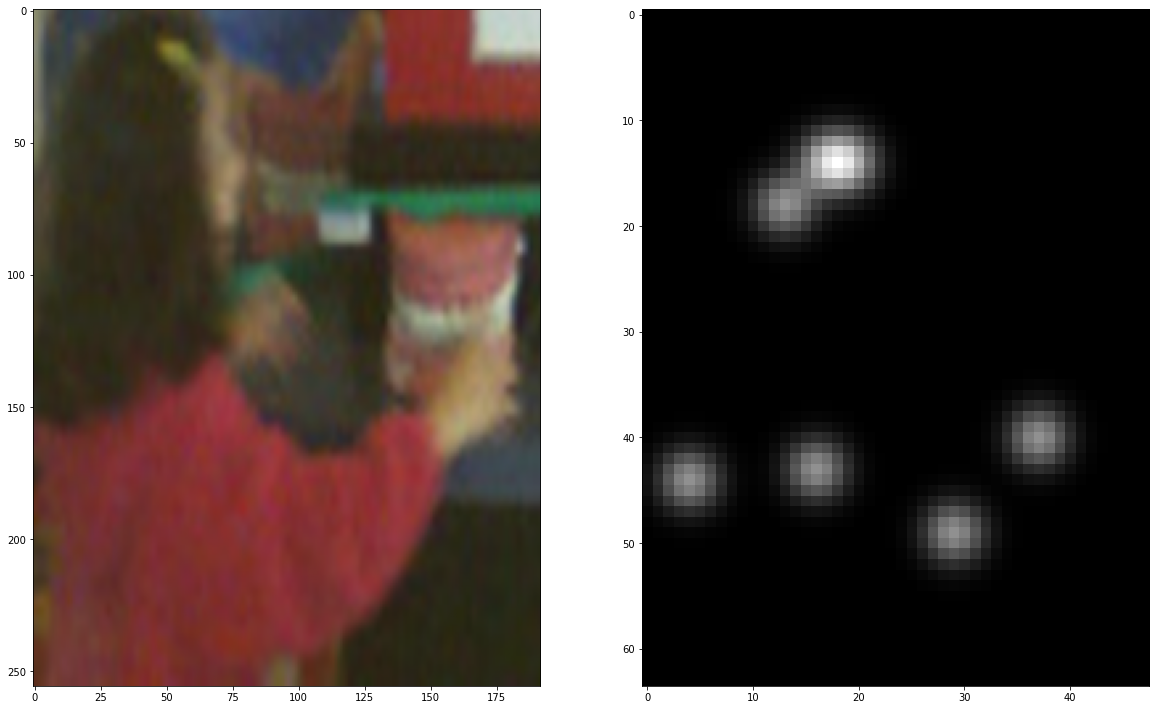

In [52]:
print("GROUNDTRUTH HEATMAP")
plotting_data(single_train_img,single_train_gt_heatmap,single_train_gt_validity)

In [53]:
pretrained_pose_resnet.trainable = False
train_img_heatmap_pred = pretrained_pose_resnet(single_train_img,training=False)

PREDICTED HEATMAP


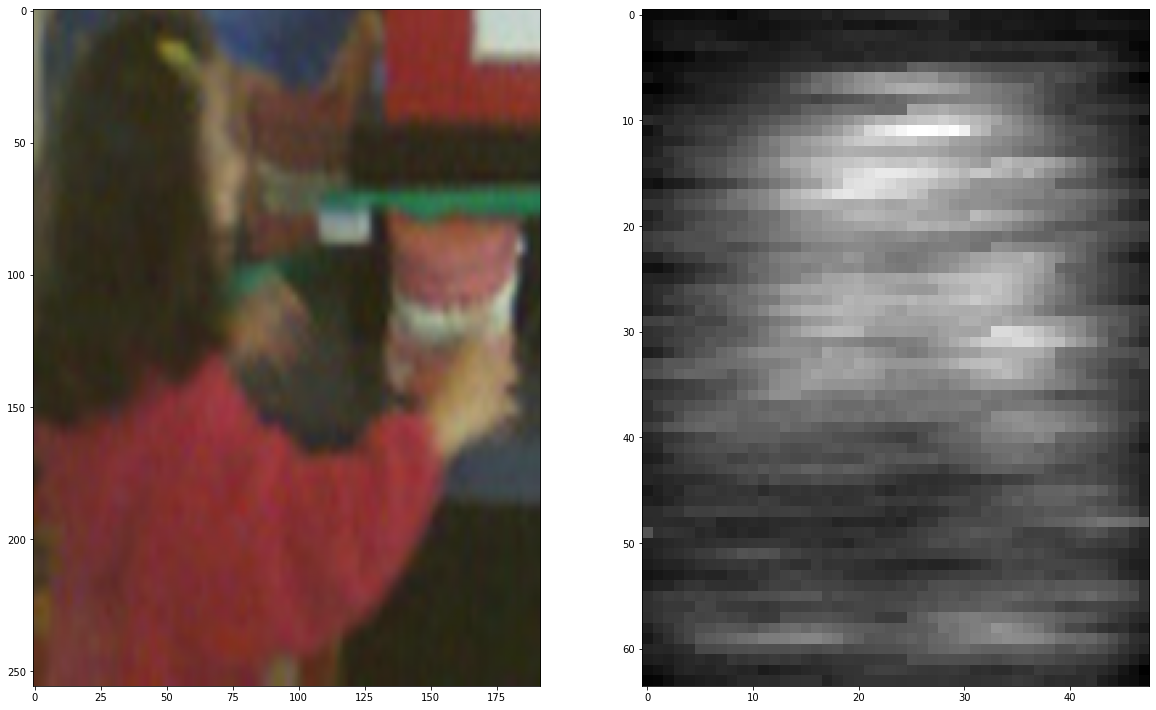

In [54]:
print("PREDICTED HEATMAP")
plotting_data(single_train_img,train_img_heatmap_pred.numpy(),single_train_gt_validity)